This project focuses on leveraging linear algebra methods, specifically SVD Decomposition, to construct a stock market portfolio from the S&P 500 stocks. I utilized a dataset containing daily returns of all current S&P 500 stocks since 2012. By calculating the daily price returns of the current S&P 500 components, I created a portfolio using Principal Component Analysis (PCA) through SVD, also referred to as an eigen-portfolio. This portfolio is then compared to the S&P 500 Equal Weight Index, represented by the RSP ETF (Invesco S&P 500 Equal Weight ETF).

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import yfinance as yf

In [615]:
df = pd.read_csv('data/portfolio.csv')
df.shape

(3751, 431)

# Data pre-processing

In [616]:
df = df.drop(labels=['Unnamed: 0', 'Date'],axis='columns')
df = df.dropna(axis='rows').reset_index(drop=True)
benchmark = df['RSP']/df['RSP'][0]
benchmark_daily = df['RSP'].drop(0)
benchmark_train = benchmark[:2800]
df = df.drop(labels=['RSP'],axis='columns')
df = df.pct_change()
df = df.dropna(axis='rows').reset_index(drop=True)


In [617]:
len(benchmark)

3751

In [618]:
df.shape

(3750, 428)

In [619]:
df.describe()

,A,AAL,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,...,WRB,WST,WTW,WY,WYNN,XEL,XOM,YUM,ZBH,ZBRA
count,3750.000000,3750.000000,3750.000000,3750.000000,3750.000000,3750.000000,3750.000000,3750.000000,3750.000000,3750.000000,...,3750.000000,3750.000000,3750.000000,3750.000000,3750.000000,3750.000000,3750.000000,3750.000000,3750.000000,3750.000000
mean,0.000798,0.001021,0.001179,0.000588,0.000851,0.000767,0.000954,0.000875,0.000468,0.000752,...,0.000740,0.000976,0.000552,0.000614,0.000867,0.000510,0.000426,0.000642,0.000448,0.000966
std,0.018069,0.033655,0.017616,0.013485,0.014832,0.015194,0.019997,0.018251,0.016417,0.013747,...,0.013813,0.017040,0.014178,0.019469,0.029285,0.012176,0.015718,0.015010,0.016177,0.022488
min,-0.110139,-0.252246,-0.128647,-0.097856,-0.168752,-0.103815,-0.190346,-0.166149,-0.241971,-0.152526,...,-0.154325,-0.140841,-0.107318,-0.226733,-0.244346,-0.126918,-0.122248,-0.188324,-0.139943,-0.238459
25%,-0.007823,-0.015763,-0.007397,-0.006051,-0.005660,-0.006443,-0.008124,-0.008237,-0.007379,-0.005381,...,-0.005783,-0.007441,-0.005735,-0.009050,-0.013404,-0.005580,-0.007175,-0.006235,-0.007315,-0.009586
50%,0.001025,0.000000,0.000979,0.000606,0.001005,0.001092,0.001043,0.000936,0.000901,0.000920,...,0.000916,0.000944,0.000697,0.000901,-0.000083,0.000640,0.000144,0.000825,0.000228,0.000974
75%,0.010274,0.016505,0.010474,0.007705,0.007605,0.008249,0.010879,0.010169,0.008999,0.007656,...,0.007495,0.009403,0.007200,0.010246,0.014107,0.007151,0.007942,0.007640,0.008493,0.011301
max,0.117630,0.410970,0.119808,0.109360,0.153577,0.128573,0.177193,0.146977,0.102695,0.118036,...,0.119554,0.145390,0.151057,0.253155,0.276883,0.112577,0.126868,0.232484,0.155798,0.172142


In [620]:
df.sample(5)

,A,AAL,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,...,WRB,WST,WTW,WY,WYNN,XEL,XOM,YUM,ZBH,ZBRA
3039,0.002665,-0.025063,-0.002782,-0.004504,0.002034,-0.005494,0.007082,0.023121,-0.017394,-0.006747,...,-0.008270,0.014093,-0.008218,-0.014476,-0.041965,0.003639,-0.023368,0.000750,-0.035652,0.024253
3723,-0.012284,-0.021785,0.012702,-0.006506,-0.006291,-0.010384,0.008924,0.034592,-0.003722,-0.000932,...,-0.015554,-0.011456,0.003034,-0.005361,-0.017810,0.001086,0.000165,0.012206,-0.002880,0.003507
2412,-0.012713,-0.016050,-0.018940,-0.010206,0.003304,-0.012599,-0.002398,-0.017381,-0.011225,0.000962,...,0.012018,-0.010587,-0.021580,-0.013704,-0.034766,0.013351,-0.007707,0.000211,0.000931,-0.021963
2742,0.020082,0.058095,0.012298,-0.020122,0.031184,0.008729,0.007967,-0.001505,-0.010684,-0.006417,...,0.000172,-0.018052,-0.002169,0.042595,0.038305,0.011072,0.017814,0.008804,0.012189,0.013968
2306,-0.004608,-0.026981,-0.006525,-0.016540,0.000000,-0.005074,-0.039523,-0.002446,-0.004992,0.002263,...,-0.001270,0.001721,0.000339,0.006440,-0.018598,0.016082,0.013327,-0.003332,0.004509,-0.016416


In [621]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_train = df.iloc[:2800,:]
df_test = df.iloc[2800:,:]

train_values = scaler.fit_transform(df_train)

# Building principal components through SVD (Singular Value Decomposition)

In [622]:
from numpy.linalg import svd
u,s,vt = svd(train_values,full_matrices=False)


In [623]:
print("Shape U: {}".format(u.shape))
print("Shape S {}".format(s.shape))
print("Shape VˆT: {}".format(vt.shape))

Shape U: (2800, 428)

Shape S (428,)

Shape VˆT: (428, 428)


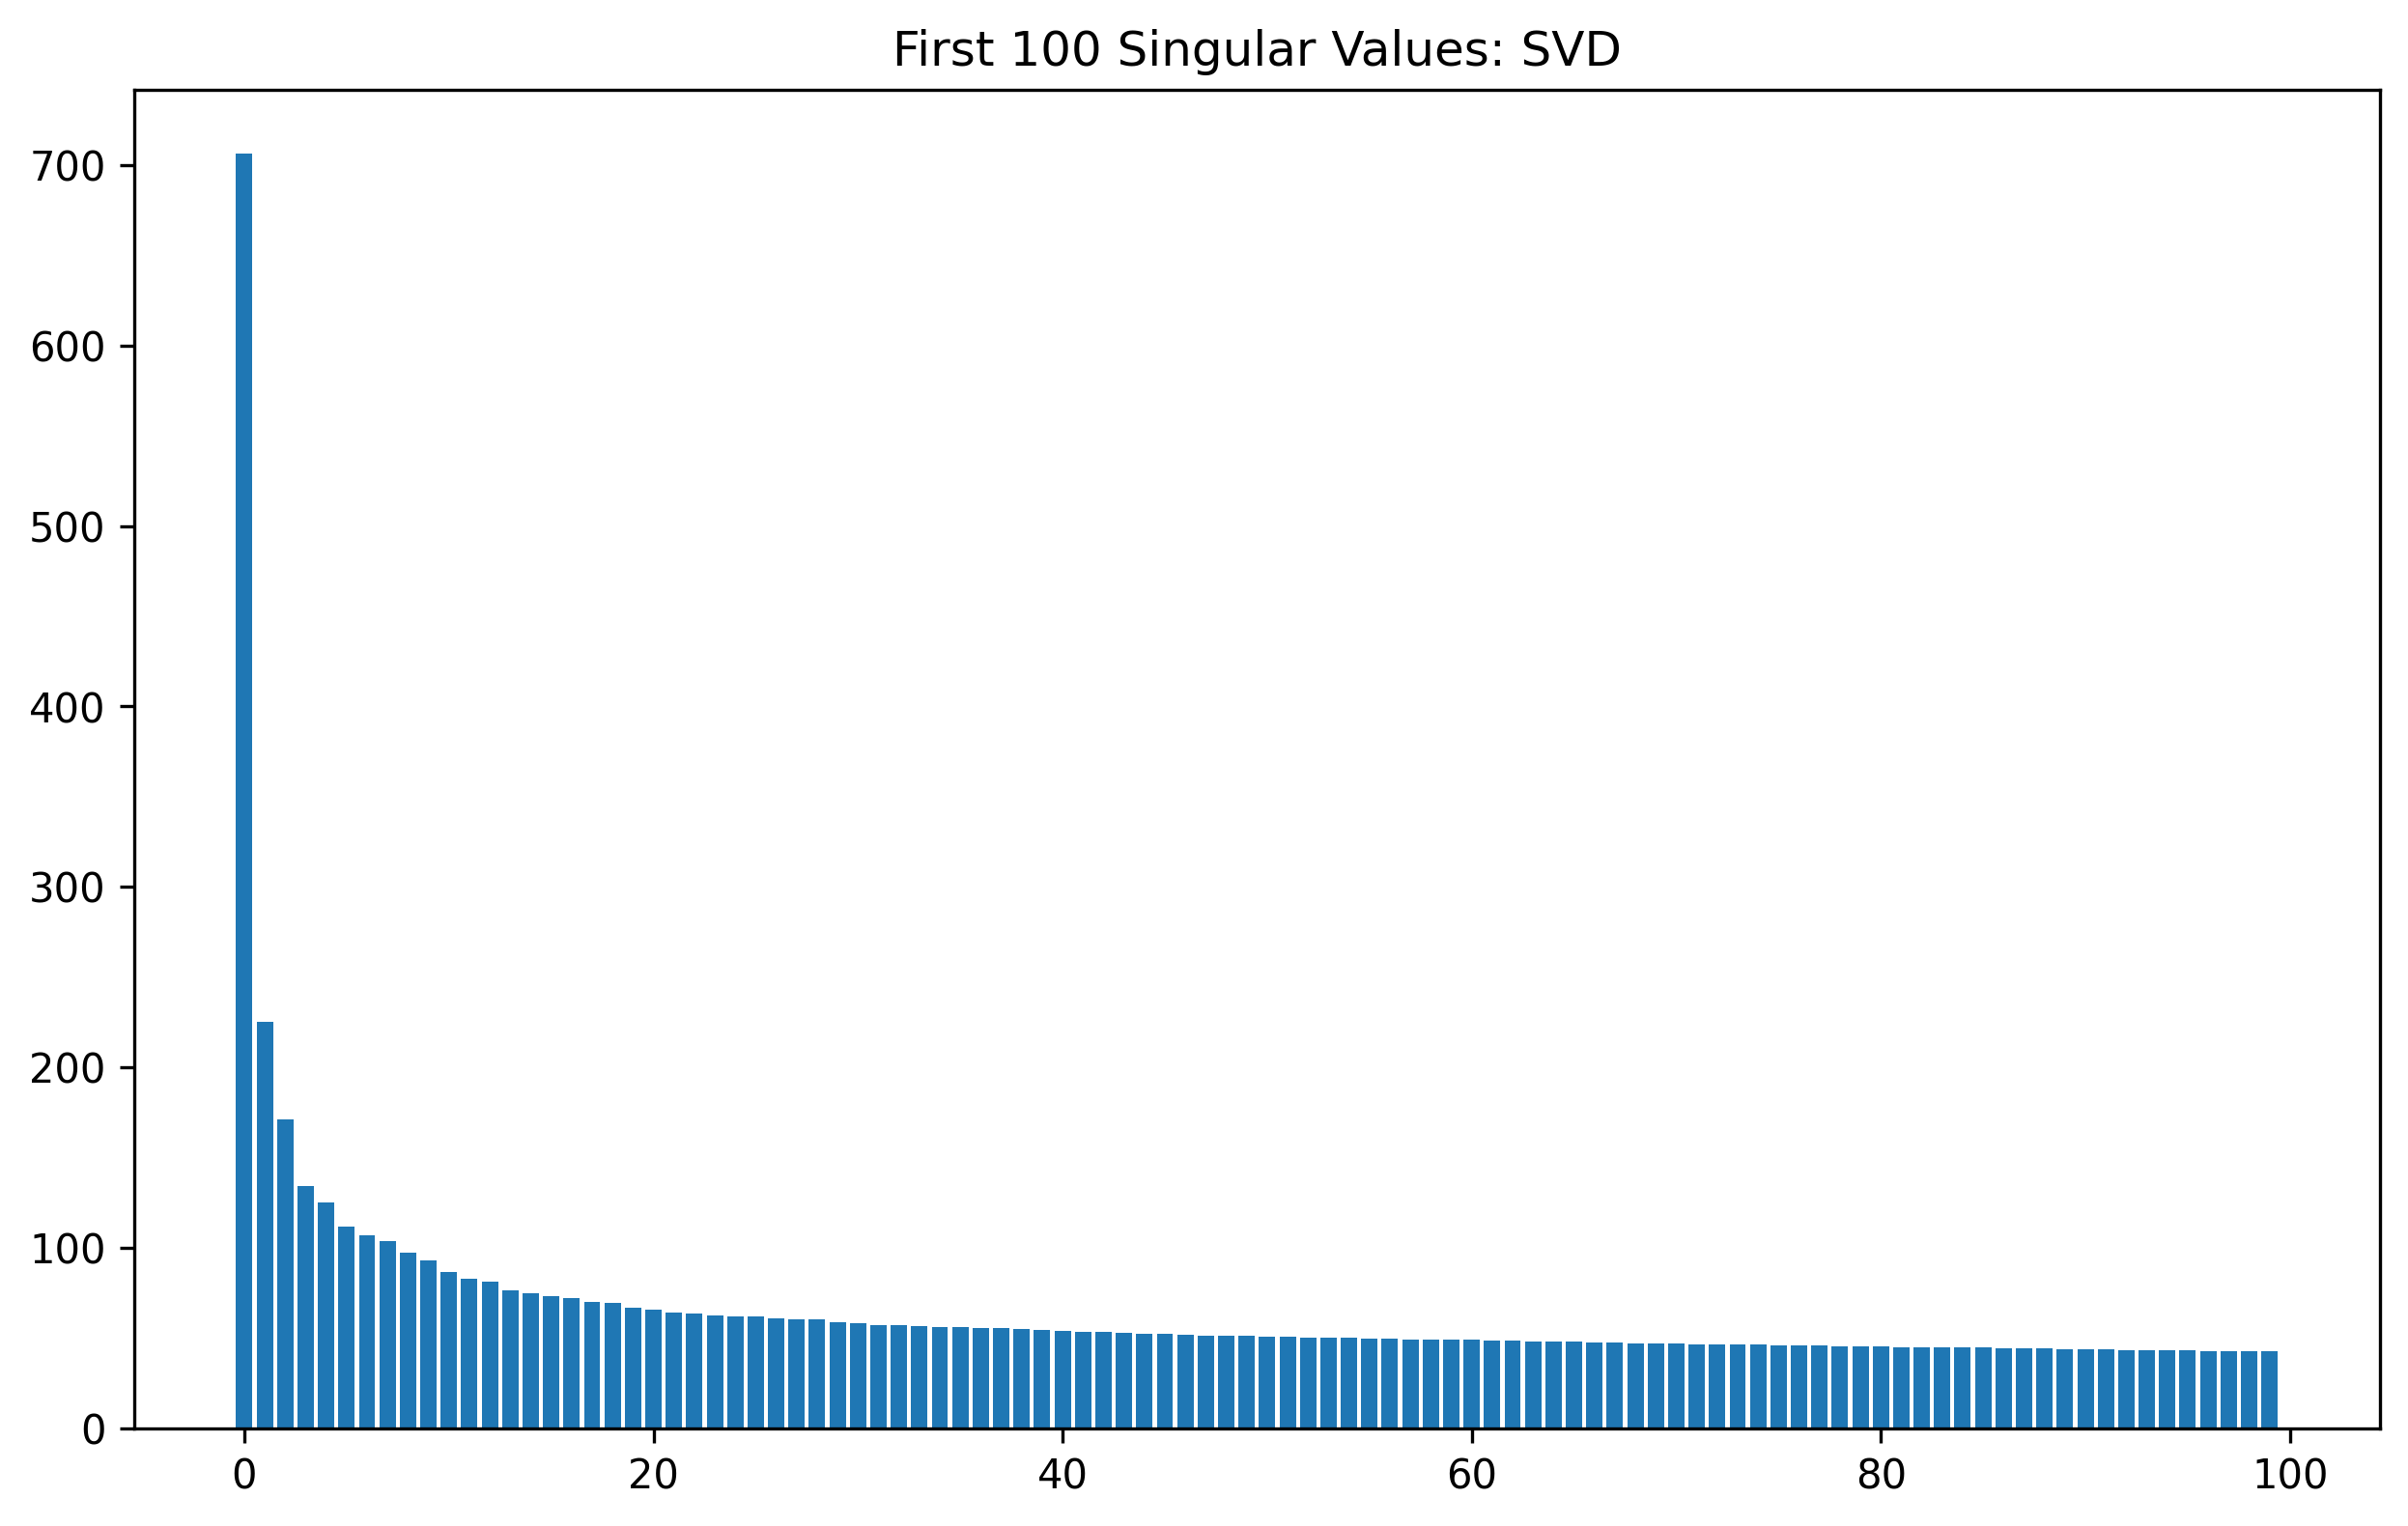

In [624]:
s_plot = s[:100]
plt.figure(figsize=(10, 6),dpi=300) 
plt.title('First 100 Singular Values: SVD')
plt.bar(range(len(s_plot)),s_plot)
plt.show()


In [625]:
#Principal components vectors!
PC1 = vt[0,:]
PC2 = vt[1,:]
PC3 = vt[2,:]
PC4 = vt[3,:]

In [626]:
vt[0,:].shape


(428,)

In [627]:
train_values.shape

(2800, 428)

In [628]:
from sklearn.decomposition import PCA

pca = PCA()

pca.fit(train_values)

PCA()

In [629]:
train_values.shape

(2800, 428)

In [630]:
PC1.sum(),PC2.sum(),PC3.sum()

(-20.399767868645775, 0.9422004159556905, 1.0867175979659967)

In [631]:
-1*pca.components_[0][:5],PC1[:5]

(array([0.05522945, 0.03689321, 0.04440624, 0.04800674, 0.05312809]),
 array([-0.05522945, -0.03689321, -0.04440624, -0.04800674, -0.05312809]))

# Normalizing Principal Components (Create Weights)

In [632]:
weights_1 = PC1 / np.sum(PC1) 
weights_2 = PC2 / np.sum(PC2)
weights_3 = PC3 / np.sum(PC3)


In [633]:
ptfl1 = np.dot(df_train,(weights_1))
ptfl1_test = np.dot(df,weights_1)

# Benchmark Comparison

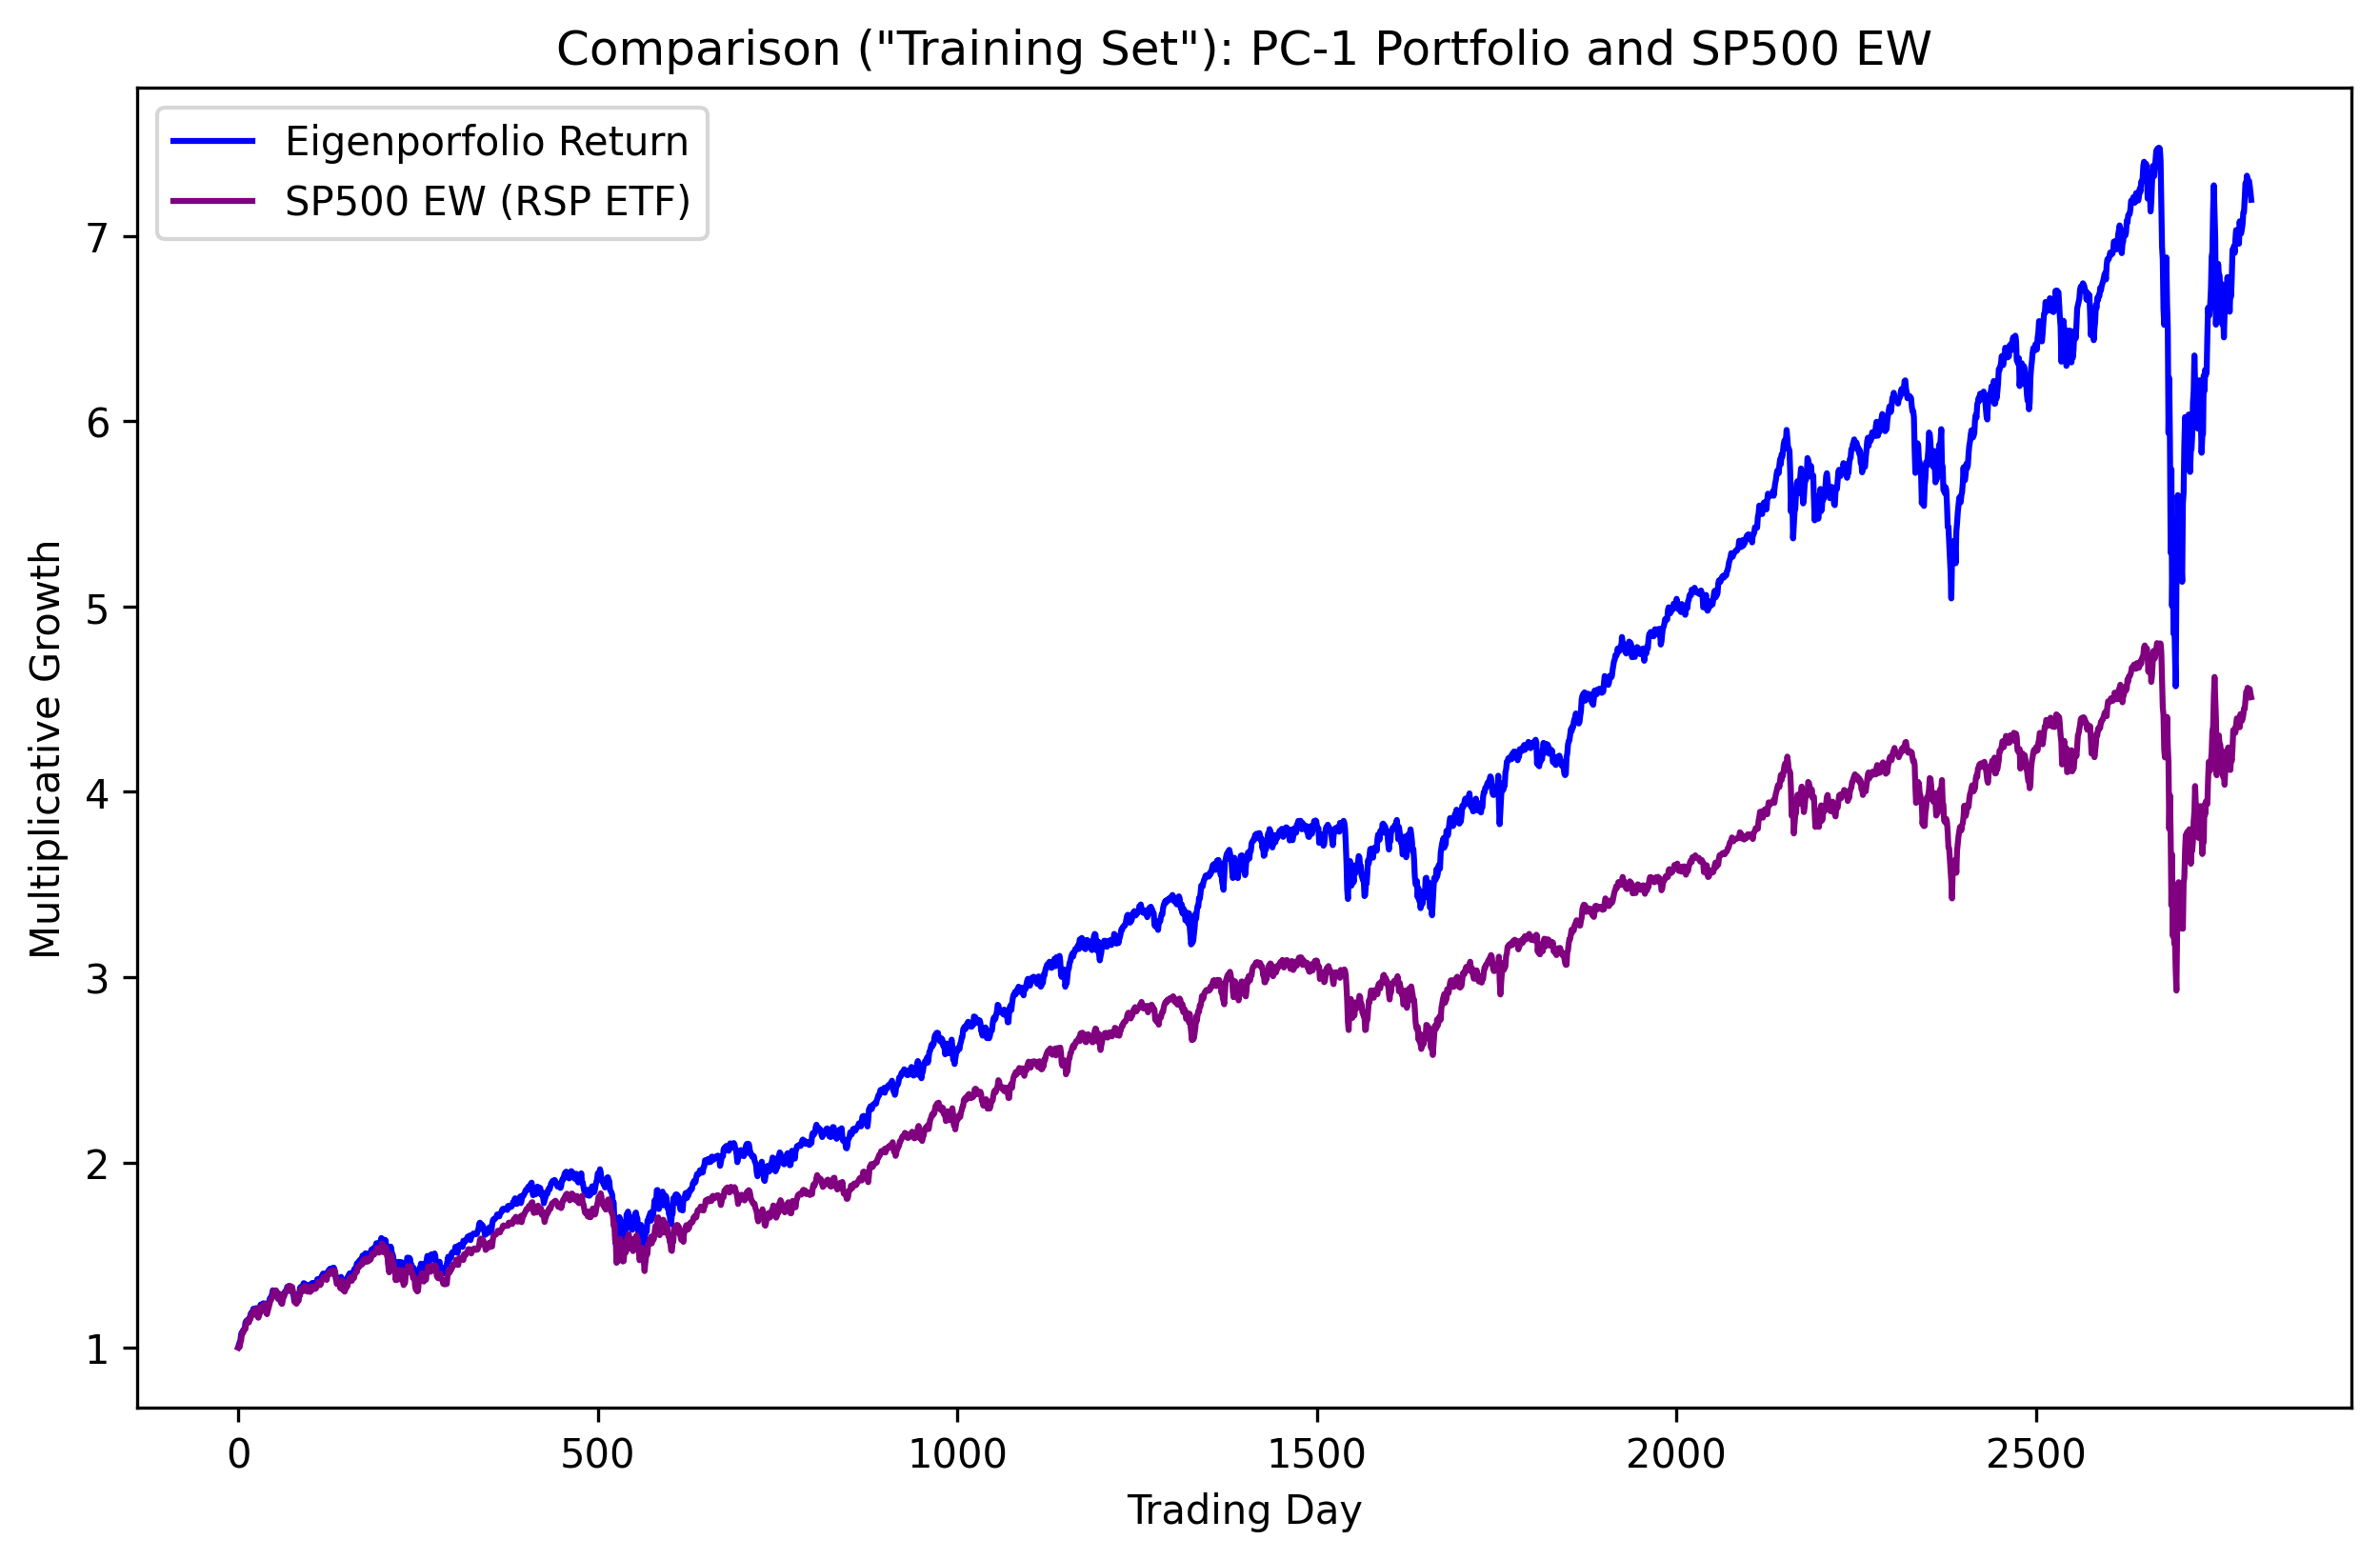

In [634]:
eigen_return1 = (1+ptfl1).cumprod()
plt.figure(figsize=(10, 6),dpi=300)  # Adjust figure size as needed
plt.plot(eigen_return1, label='Eigenporfolio Return',color='blue')
plt.plot(benchmark_train, label='SP500 EW (RSP ETF)',color='purple')
plt.xlabel("Trading Day")
plt.ylabel("Multiplicative Growth")
plt.title('Comparison ("Training Set"): PC-1 Portfolio and SP500 EW')
plt.legend()



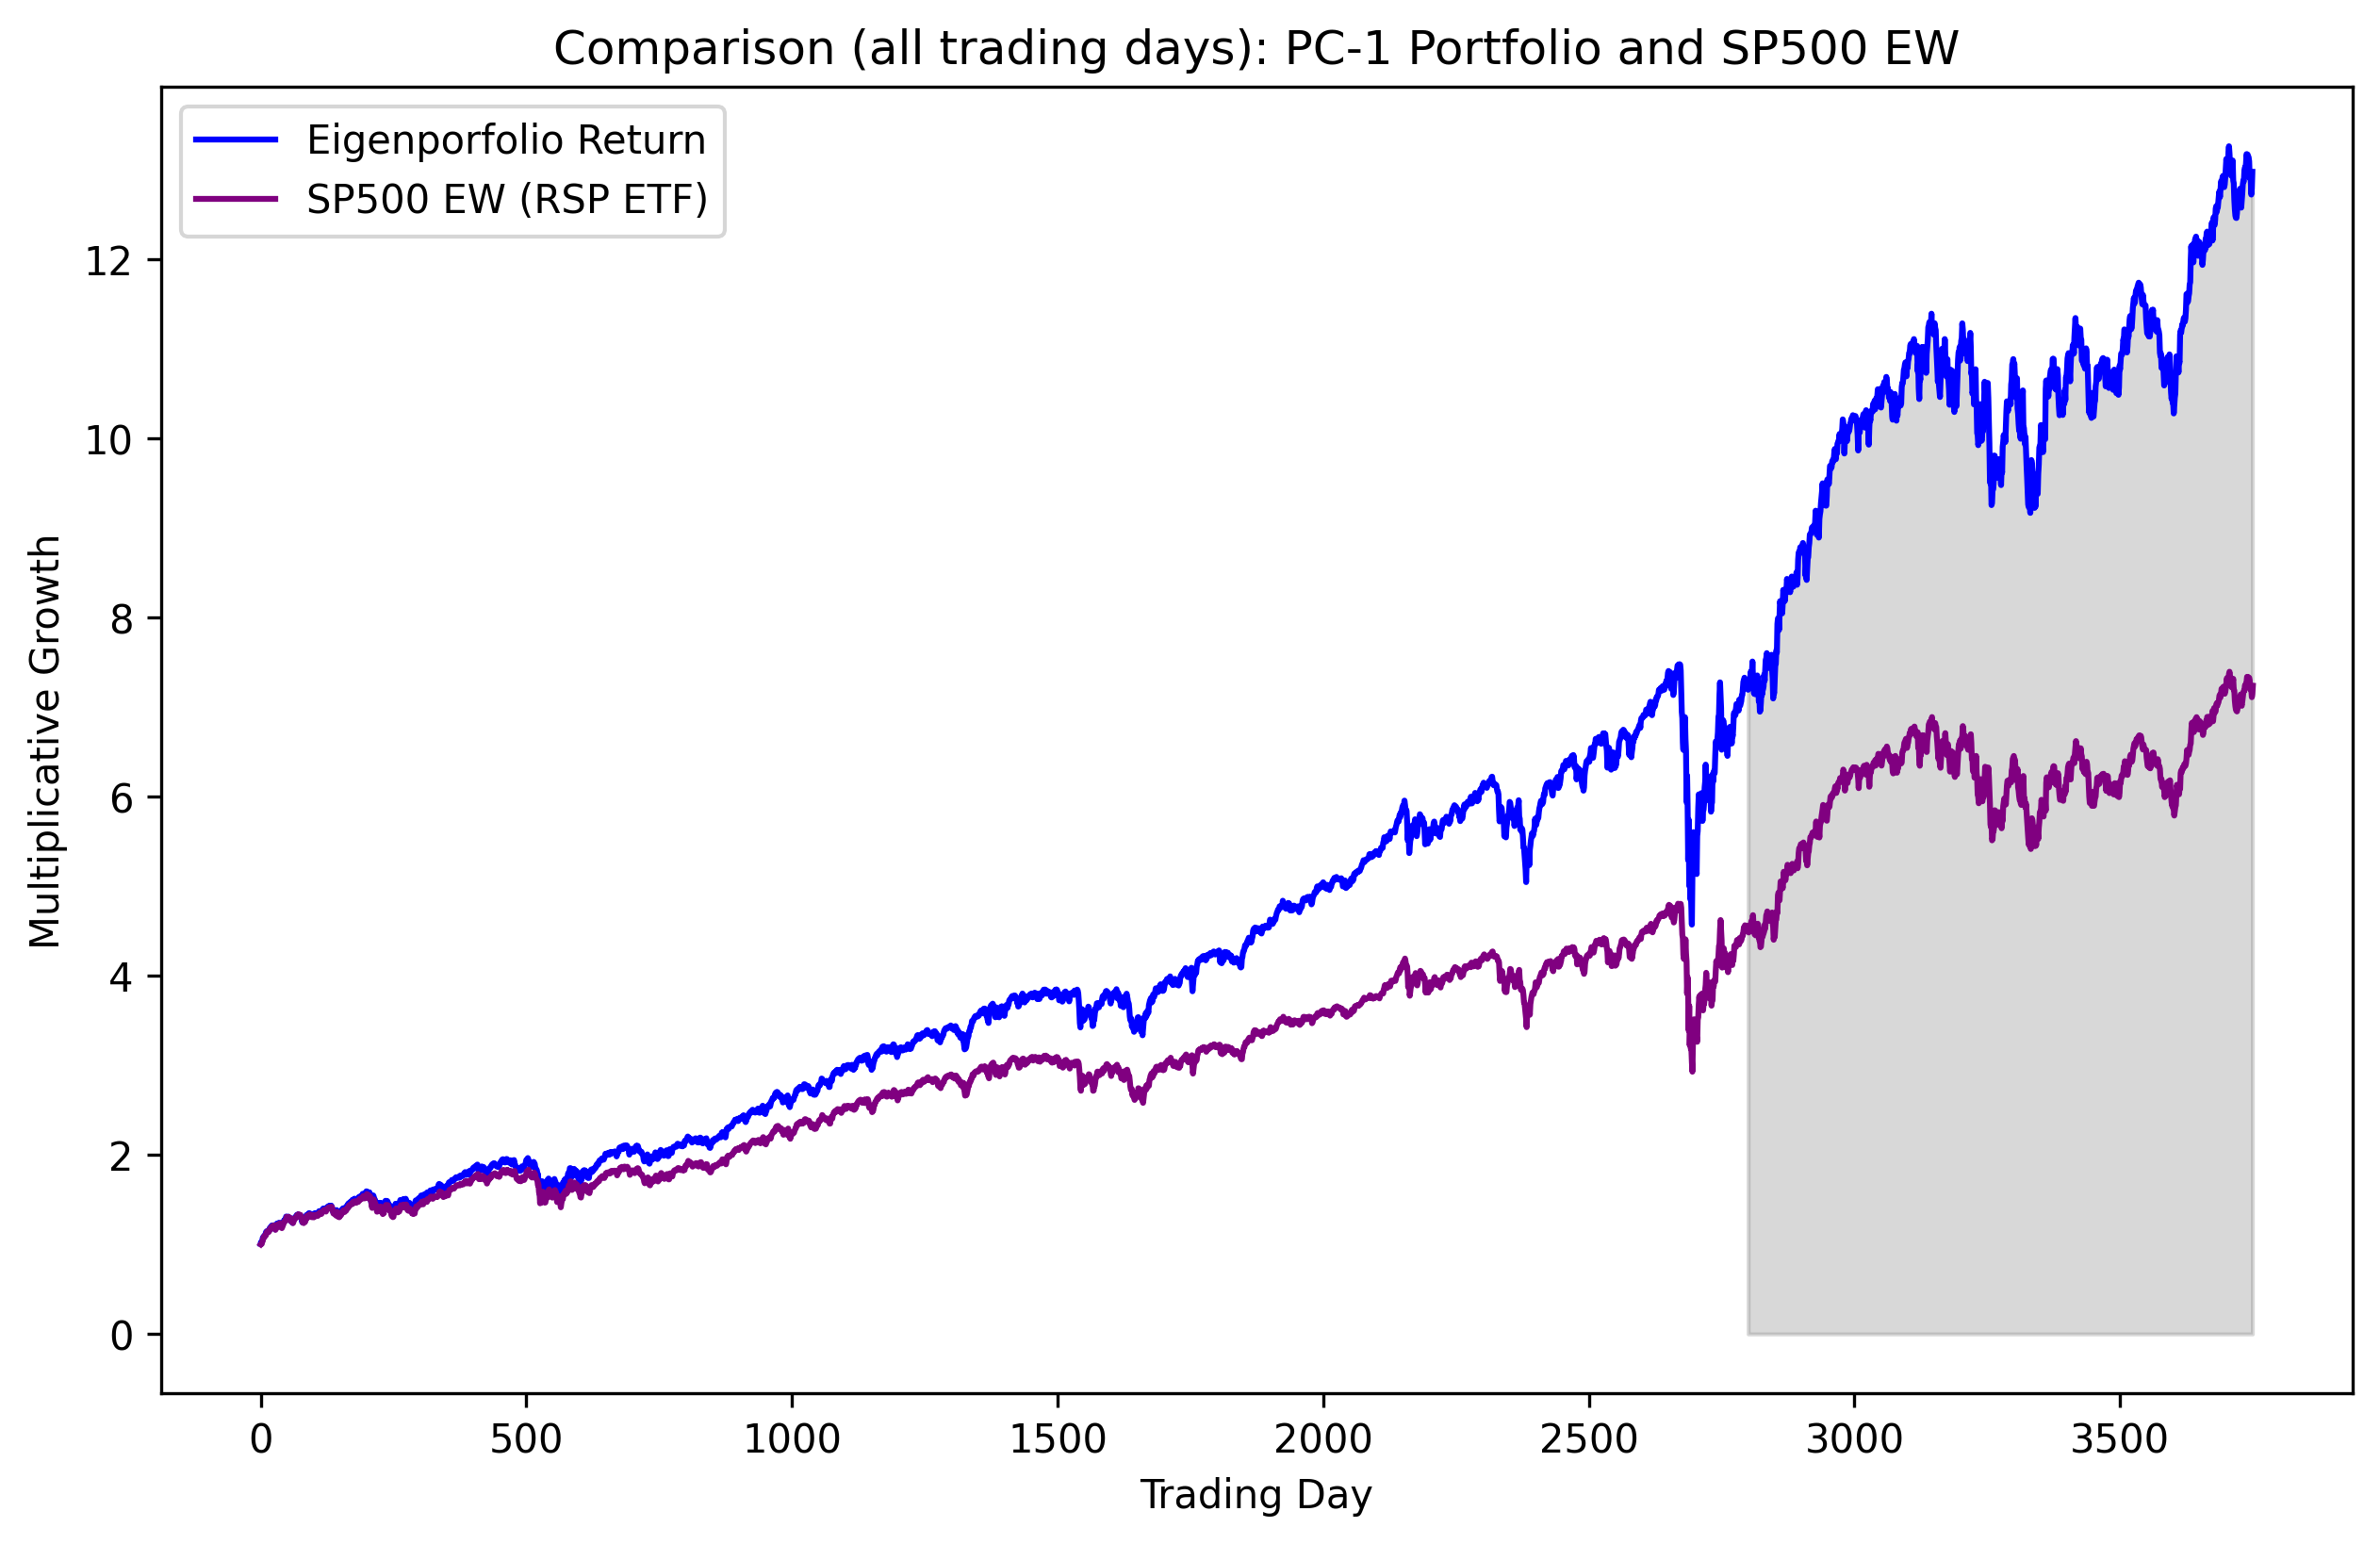

In [635]:
eigen_return1 = (1+ptfl1_test).cumprod()
plt.figure(figsize=(10, 6),dpi=300)  # Adjust figure size as needed
plt.plot(eigen_return1, label='Eigenporfolio Return',color='blue')
plt.plot(benchmark, label='SP500 EW (RSP ETF)',color='purple')
plt.xlabel("Trading Day")
plt.ylabel("Multiplicative Growth")
plt.fill_between(df.index[2800:], eigen_return1[2800:], color='gray', alpha=0.3)

plt.title("Comparison (all trading days): PC-1 Portfolio and SP500 EW")
plt.legend()

In [636]:
df_train

,A,AAL,AAPL,ABT,ACGL,ACN,ADBE,ADI,ADM,ADP,...,WRB,WST,WTW,WY,WYNN,XEL,XOM,YUM,ZBH,ZBRA
0,0.003721,0.009346,-0.006267,-0.008206,0.014593,-0.007963,0.035890,0.024297,0.018463,-0.008248,...,-0.012471,-0.024346,0.014840,0.007225,0.067536,0.000553,-0.004376,-0.005964,-0.006994,-0.009677
1,0.004238,-0.046296,0.015840,-0.011321,-0.003938,0.009571,0.005835,-0.003329,-0.013688,0.001782,...,-0.019178,-0.006470,-0.006093,0.003228,-0.029753,-0.001104,-0.012885,-0.000572,-0.013078,-0.003723
2,0.022679,0.024272,0.027577,0.025328,0.043149,0.020183,0.028644,0.013361,0.015754,0.011266,...,0.045780,0.017984,0.033102,0.040043,0.042931,0.019348,0.008906,0.019726,0.034404,0.004204
3,0.005157,-0.033175,-0.000491,0.007367,-0.018457,0.010492,-0.002467,-0.003709,0.006647,0.009675,...,-0.011856,-0.007615,0.008703,-0.001719,0.046116,0.011931,0.007915,0.015699,0.002710,0.015814
4,0.054900,0.029412,0.032403,-0.026027,0.023674,0.009789,0.054770,0.031431,0.024945,0.019454,...,0.005999,0.025476,0.022745,0.047521,0.070710,0.016612,0.033525,-0.055216,0.014988,0.027930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2795,-0.014174,0.002256,-0.000891,-0.010979,-0.003399,-0.006387,-0.005378,-0.007874,0.003601,-0.002154,...,-0.009069,-0.009776,0.013887,-0.004912,-0.019499,-0.007716,0.004418,-0.001294,-0.004278,0.001471
2796,0.001438,-0.053263,-0.002611,0.007201,-0.015194,0.010293,0.008892,0.002219,-0.004485,0.005038,...,-0.021997,0.009249,0.000794,0.021157,-0.017416,-0.007493,-0.012963,0.010254,0.009176,0.002482
2797,0.003590,-0.001585,0.008333,0.002482,-0.005668,0.006921,0.026418,0.003747,0.006359,0.002076,...,0.005746,0.001164,-0.001785,-0.002763,-0.022395,-0.002849,-0.004925,0.013889,0.001587,-0.016670
2798,0.001022,0.006349,0.001255,-0.004754,-0.005700,0.001708,-0.003236,0.002290,-0.005642,-0.007503,...,-0.010284,-0.001417,0.009885,0.003117,-0.004533,-0.006000,-0.011077,-0.010221,-0.011167,0.004150


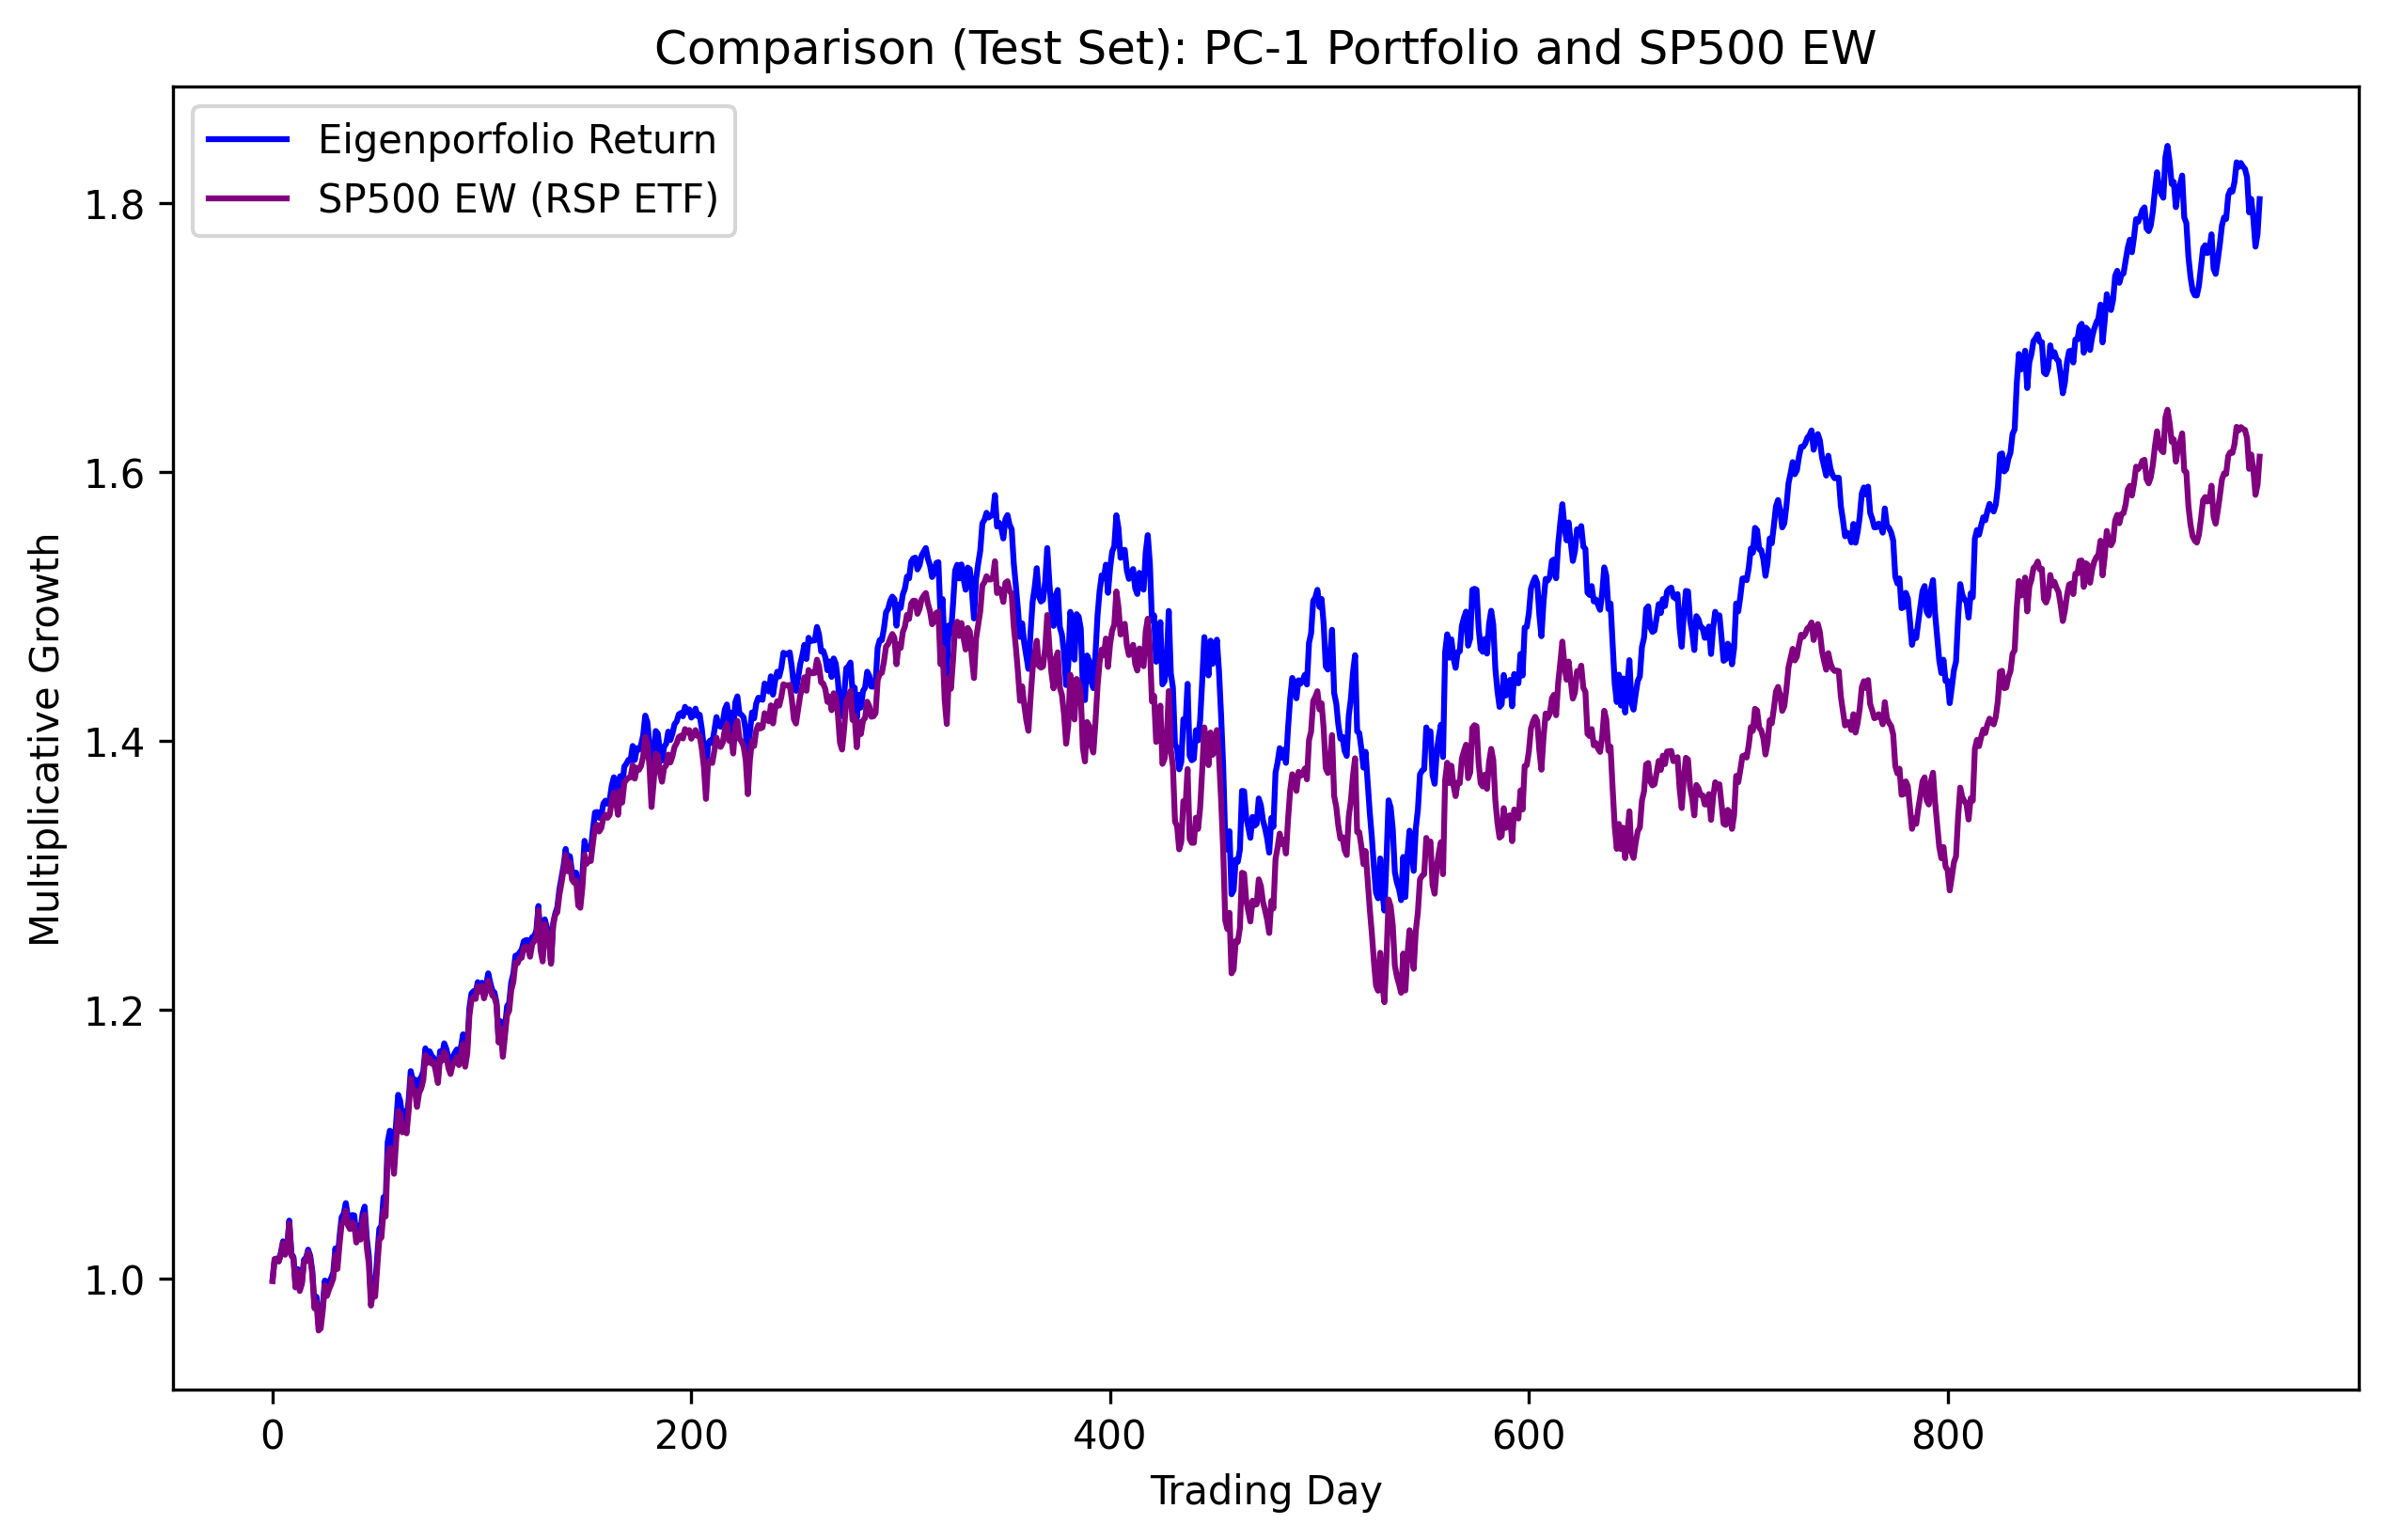

In [637]:
ptfl1_test = np.dot(df_test,weights_1)
benchmark_test = benchmark[2800:]
benchmark_test = (1+benchmark_test.pct_change()[1:]).values.cumprod()
eigen_return1 = (1+ptfl1_test).cumprod()
plt.figure(figsize=(10, 6),dpi=300)  # Adjust figure size as needed
plt.plot(eigen_return1, label='Eigenporfolio Return',color='blue');
plt.plot(benchmark_test, label='SP500 EW (RSP ETF)',color='purple');
plt.xlabel("Trading Day");
plt.ylabel("Multiplicative Growth");
plt.title("Comparison (Test Set): PC-1 Portfolio and SP500 EW");
plt.legend()

# Backtest of investment strategy:

### Conjecture: If we dynamically change the eigenportfolio, every 30 days for example, how will our portfolio perform?


In [638]:
def generate_eigenportfolio(df_daily_returns,eigenportfolio_number = 1):
    train_values = scaler.fit_transform(df_daily_returns)
    decomposed_df = svd(train_values,full_matrices=False)
    vt = decomposed_df[-1]
    PC1 = vt[eigenportfolio_number-1,:]
    weights = PC1 / np.sum(PC1) 
    #dot product, weighting our portfolio with normalized PC1 components.
    #portfolio = np.dot(df_train,weights)
    return weights

def calculate_weighted_portfolio(df_daily_returns,weights):
    portfolio = np.dot(df_daily_returns,weights)
    return portfolio
def calculate_returns(portfolio_daily_returns):
    portfolio_returns = (1+portfolio_daily_returns).cumprod()
    return portfolio_returns
def grab_window_df(df, window_size, start_index):
    return df[start_index:start_index + window_size]




# Tests and Results

In [640]:
# Parameters
window_size = 30  # Number of days in each rolling window
eigenportfolio_number = 1

all_portfolio_returns = []
all_benchmark_returns = []

#rolling window implementation
for start in range(0, len(df) - 2*window_size, window_size):
    #Grab the training and testing windows
    train_df = grab_window_df(df, window_size, start)
    test_df = grab_window_df(df, window_size, start + window_size)
    
    #Generate eigenportfolio weights
    weights = generate_eigenportfolio(train_df, eigenportfolio_number)
    
    # Calculate portfolio returns
    portfolio_daily_returns = calculate_weighted_portfolio(test_df, weights)
    portfolio_total_return = np.prod(1 + portfolio_daily_returns)  # Total return calculation
    all_portfolio_returns.append(portfolio_total_return)
    
    # Calculate benchmark returns for the same period
    benchmark_window = grab_window_df(benchmark_daily, window_size, start + window_size)
    benchmark_daily_returns = benchmark_window.pct_change().dropna()
    benchmark_total_return = np.prod(1 + benchmark_daily_returns)  # Total return calculation
    all_benchmark_returns.append(benchmark_total_return)

# Calculate mean total returns
mean_portfolio_return = np.mean(all_portfolio_returns)
mean_benchmark_return = np.mean(all_benchmark_returns)

print("Mean Portfolio Total Return:", mean_portfolio_return)
print("Mean Benchmark Total Return:", mean_benchmark_return)
print("Performance Spread PC-1 and SP500 EW: {}".format(mean_portfolio_return-mean_benchmark_return))


Mean Portfolio Total Return: 1.0215634302270278

Mean Benchmark Total Return: 1.015228187728569

Performance Spread PC-1 and SP500 EW: 0.0063352424984588485


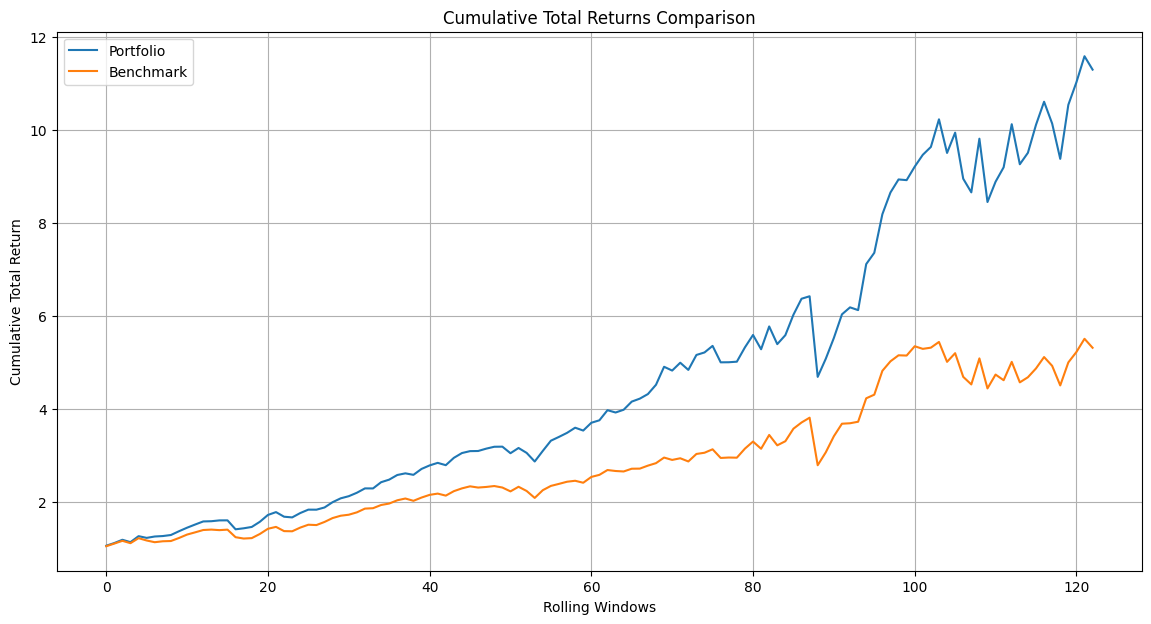

In [641]:
import matplotlib.pyplot as plt

# Plotting the cumulative total returns
plt.figure(figsize=(14, 7))

#Portfolio - eigenportfolio
plt.plot(np.cumprod(all_portfolio_returns), label='Portfolio')
#Benchmark
plt.plot(np.cumprod(all_benchmark_returns), label='Benchmark')

plt.title('Cumulative Total Returns Comparison')
plt.xlabel('Rolling Windows')
plt.ylabel('Cumulative Total Return')
plt.legend()
plt.grid(True)
plt.show()


Disclaimer: This is NOT an investment advice, implement and use this strategy at your own risk.